In [1]:
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("/root/lib/ImageClassifier/")
import common_functions as my_functions

Using TensorFlow backend.


In [2]:
# load preprocessd image numpy data, split train and validation
def load_dataset(size, data_type, fold_num, validation_no=None):
    ndarr = np.load(str(size) + '.npz')
    x, y =  my_functions.split_dataset_leave_one_out(ndarr['x'], ndarr['y'], data_type, fold_num, validation_no)
    x = x.astype('float32')
    x /= 255
    print(data_type, 'x', x.shape, '  y', y.shape)
    return x, y 


# Run train model  pipeline

In [3]:
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime

num_classes = 17
last_activation = 'sigmoid'

def run_train(network_name, shape, fold_num, validation_no=0, freeze_layer_type=None, optimizer='Adam'):
    # load train dataset
    x_train, y_train =  load_dataset(shape[0], 'train', fold_num, validation_no)
    
    #  Image data augmentation
    datagen = ImageDataGenerator(
            horizontal_flip=True,
            vertical_flip=True,
            rotation_range= 30,
            zoom_range=0.1,  
            shear_range=0.1,
            width_shift_range=0.1,  
            height_shift_range=0.1,
            fill_mode='reflect',
    ) 
    datagen.fit(x_train, rounds=2)
    
    # load test dataset
    x_test, y_test =  load_dataset(shape[0], 'test', fold_num, validation_no)
    
    
    # load imagenet pretrain-model
    model = eval('my_functions.'+network_name)(shape, num_classes, last_activation)
    
    '''
    model.summary()
    for i, layer in enumerate(model.layers):
        print(i, layer.name)
   ''' 
        
    # freeze layer default None, finetune, freeze_top
    if freeze_layer_type != None:
        freeze_layer_no = my_functions.get_freeze_layer_num(freeze_layer_type, network_name)
        for layer in model.layers[:freeze_layer_no]:
            #print('freeze', layer.name)
            layer.trainable = False

    # start training
    print('start train', network_name, shape, '  optimizer=',optimizer, ' freeze_layer_type=',freeze_layer_type)
    model.compile(loss='binary_crossentropy', optimizer=my_functions.get_optimizer(optimizer,freeze_layer_type),  metrics=['accuracy'])
    
    batch_size = my_functions.get_bach_size(network_name, shape[0], freeze_layer_type)
    history = model.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        steps_per_epoch=x_train.shape[0] // batch_size,
        epochs=1000,
        validation_data=(x_test, y_test),
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=5),
            ModelCheckpoint("../weights/working.h5", monitor="val_loss", save_best_only=True, save_weights_only=True)
        ]
    )
    
    # load best score  and save
    bst_loss = min(history.history['val_loss'])
    bst_acc =  max(history.history['val_acc'])
    
    file_name = datetime.now().strftime('%m%d_%H%M')
    file_name += '_'+network_name
    file_name += '_'+str(shape[0])
    file_name += '_'+optimizer
    file_name += '_fold'+ str(fold_num) +'-'+ str(validation_no)
    if freeze_layer_type != None:
        file_name += '_freeze_'+freeze_layer_type
        
    save_path = '../weights/'+ file_name +'_' + 'loss_%.4f_'%(bst_loss) + 'acc_%.4f_'%(bst_acc) +'.h5'
    model.save_weights(save_path)
    
    
    my_functions.plot_history(history)
    print(save_path)
    
    y_test, y_pred = run_check(save_path)
    get_optimal_threshhold(y_test, y_pred)
    
    del x_train, y_train, x_test, y_test, datagen
    gc.collect()
    
    return history

In [4]:
def run_full_train(network_name, shape, freeze_layer_type=None, optimizer='Adam'):
    # load train dataset
    ndarr = np.load(str(shape[0]) + '.npz')
    x, y = ndarr['x'], ndarr['y']
    x = x.astype('float32')
    x /= 255
    
    #  Image data augmentation
    datagen = ImageDataGenerator(
            horizontal_flip=True,
            vertical_flip=True,
            rotation_range= 30,
            zoom_range=0.1,  
            shear_range=0.1,
            width_shift_range=0.1,  
            height_shift_range=0.1,
            fill_mode='reflect',
    ) 
    datagen.fit(x, rounds=2)
    
    # load imagenet pretrain-model
    model = eval('my_functions.'+network_name)(shape, num_classes, last_activation)
        
    # freeze layer default None, finetune, freeze_top
    if freeze_layer_type != None:
        freeze_layer_no = my_functions.get_freeze_layer_num(freeze_layer_type, network_name)
        for layer in model.layers[:freeze_layer_no]:
            #print('freeze', layer.name)
            layer.trainable = False

    # start training
    print('start train', network_name, shape, '  optimizer=',optimizer, ' freeze_layer_type=',freeze_layer_type)
    model.compile(loss='binary_crossentropy', optimizer=my_functions.get_optimizer(optimizer,freeze_layer_type),  metrics=['accuracy'])
    
    ft = datetime.now().strftime('%m%d_%H%M') +'_'+  network_name + '_' + str(shape[0])
    batch_size = my_functions.get_bach_size(network_name, shape[0], freeze_layer_type)
    history = model.fit_generator(
        datagen.flow(x, y, batch_size=batch_size),
        steps_per_epoch=x.shape[0] // batch_size,
        epochs= 18,
        callbacks=[
            ModelCheckpoint("../fullweights/"+ ft +"_{epoch:02d}_{loss:.4f}_{acc:.4f}.h5", save_best_only=False, save_weights_only=True)
        ]
    )
        
    del x, y, datagen
    gc.collect()


# check score fn

In [5]:
from sklearn.metrics import fbeta_score
def f2_score(y_true, y_pred):
    # fbeta_score throws a confusing error if inputs are not numpy arrays
    #y_true, y_pred, = np.array(y_true), np.array(y_pred)
    # We need to use average='samples' here, any other average method will generate bogus results
    return fbeta_score(y_true, y_pred, beta=2, average='samples')

In [6]:
def get_optimal_threshhold(true_label, prediction, iterations = 100):
    true_label, prediction, = np.array(true_label), np.array(prediction)
    best_threshhold = [0.2]*17    
    for t in range(17):
        best_fbeta = 0
        temp_threshhold = [0.2]*17
        for i in range(iterations):
            temp_value = i / float(iterations)
            temp_threshhold[t] = temp_value
            temp_fbeta = fbeta(true_label, prediction > temp_threshhold)
            if  temp_fbeta > best_fbeta:
                best_fbeta = temp_fbeta
                best_threshhold[t] = temp_value
                
    print(best_fbeta, best_threshhold)

    return best_threshhold

def fbeta(true_label, prediction):
       return fbeta_score(true_label, prediction, beta=2, average='samples')

In [7]:
def run_check(weights):
    ws = weights.split('_')
    print(ws)
    network_name = ws[2]
    shape = ws[3]
    a = ws[5]
    fold_num = int(a[4])
    validation_no =int(a[6] )
    print(a, fold_num, validation_no)
    
    x_test, y_test = load_dataset(shape, 'test', fold_num, validation_no)
    print(network_name, shape, num_classes, last_activation)
    
    # load imagenet pretrain-model
    model = eval('my_functions.'+network_name)((x_test.shape[1], x_test.shape[2], x_test.shape[3]), num_classes, last_activation)

    model.load_weights(weights)
    y_pred = model.predict(x_test)
    return y_test, y_pred

In [8]:
import os
def run_full_check(weights):
    ws = weights.split('_')
    print(ws)
    network_name = ws[2]
    shape = ws[3]
    
    # load train dataset
    ndarr = np.load(str(shape) + '.npz')
    x, y = ndarr['x'], ndarr['y']
    
    print('load dataset complete')
    model = eval('my_functions.'+network_name)((x.shape[1], x.shape[2], x.shape[3]), num_classes, last_activation)
    model.load_weights(weights)
    
    p = []
    print('model complete')
    
    for flip in ['normal', 'lr', 'ud', 'udlr']:
        for rotate in ['normal', 90]:
            result_path = weights+'_'+flip+'_'+str(rotate)+'_train_predict.npz'
            print(result_path) 
            if os.path.exists(result_path):
                ndarr = np.load(result_path)
                p.append(ndarr['threshhold'])
            else:
                pred = model.predict( my_functions.tta_images(x, flip=flip, rotate=rotate) )
                threshhold = get_optimal_threshhold(y, pred)
                p.append(threshhold)
                np.savez(result_path, y=y, pred=pred, threshhold=threshhold)
    return p

In [9]:
labels = ['haze','primary', 'agriculture', 'clear', 'water', 'habitation', 'road',
 'cultivation','slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine',
 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']

# start training
automatically use imagenet pre-trained model, bach size detect, early stop and save best weight

### Paramater
- network_name  (VGG16, ResNet50, InceptionV3, Xception, InceptionV1, squeezNet, DenseNet121, DenseNet161)
- shape (299,299,3)
- fold_num
- test_dataset_no
- freeze_layer_type (None, finetune, topblock)
- Optimizer (SGD, Adam, Nadam)

### Example
** train ResNet50 full layer training **  
` run_train('ResNet50', (224,224,3), fold_num=5, validation_no=1)  `

** train VGG16 Finetune training , if train class contain ImageNet **  
` run_train('VGG16', (224,224,3), freeze_layer_type='finetune', fold_num=5, validation_no=1) `

** train Xception freeze top block, this is faster than full layer training  and I think this is not affect accuracy**  
` run_train('Xceptin', (299,299,3), freeze_layer_type='topblock', fold_num=5, validation_no=1)  `


# Full train

In [10]:
for i in range(2):
    run_full_train('ResNet50', (256,256,3), freeze_layer_type='topblock')

freeze_layer= 17
start train ResNet50 (256, 256, 3)   optimizer= Adam  freeze_layer_type= topblock
bach size= 72
Epoch 1/18
562/562 [==============================] - 458s - loss: 0.1863 - acc: 0.9288   
Epoch 2/18
562/562 [==============================] - 448s - loss: 0.1098 - acc: 0.9590   
Epoch 3/18
562/562 [==============================] - 447s - loss: 0.1025 - acc: 0.9614   
Epoch 4/18
562/562 [==============================] - 449s - loss: 0.0984 - acc: 0.9628   
Epoch 5/18
562/562 [==============================] - 447s - loss: 0.0955 - acc: 0.9636   
Epoch 6/18
562/562 [==============================] - 447s - loss: 0.0931 - acc: 0.9646   
Epoch 7/18
562/562 [==============================] - 447s - loss: 0.0912 - acc: 0.9653   
Epoch 8/18
562/562 [==============================] - 447s - loss: 0.0894 - acc: 0.9660   
Epoch 9/18
562/562 [==============================] - 447s - loss: 0.0883 - acc: 0.9663   
Epoch 10/18
562/562 [==============================] - 447s - loss: 

KeyboardInterrupt: 

In [10]:
run_full_train('ResNet50', (256,256,3), freeze_layer_type='topblock')

freeze_layer= 17
start train ResNet50 (256, 256, 3)   optimizer= Adam  freeze_layer_type= topblock
bach size= 72
Epoch 1/16
562/562 [==============================] - 453s - loss: 0.1822 - acc: 0.9313   
Epoch 2/16
562/562 [==============================] - 447s - loss: 0.1107 - acc: 0.9587   
Epoch 3/16
562/562 [==============================] - 446s - loss: 0.1026 - acc: 0.9614   
Epoch 4/16
562/562 [==============================] - 447s - loss: 0.0977 - acc: 0.9633   
Epoch 5/16
562/562 [==============================] - 446s - loss: 0.0953 - acc: 0.9639   
Epoch 6/16
562/562 [==============================] - 448s - loss: 0.0929 - acc: 0.9645   
Epoch 7/16
562/562 [==============================] - 446s - loss: 0.0911 - acc: 0.9654   
Epoch 8/16
562/562 [==============================] - 449s - loss: 0.0897 - acc: 0.9659   
Epoch 9/16
562/562 [==============================] - 446s - loss: 0.0879 - acc: 0.9664   
Epoch 10/16
562/562 [==============================] - 452s - loss: 

### explore best fit data augmentation

In [8]:
run_train('ResNet50', (256,256,3), fold_num=9, validation_no=0, freeze_layer_type='topblock', optimizer='Adam')

train x (35982, 256, 256, 3)   y (35982, 17)
test x (4497, 256, 256, 3)   y (4497, 17)
freeze_layer= 17
start train ResNet50 (256, 256, 3)   optimizer= Adam  freeze_layer_type= topblock
bach size= 72
Epoch 1/1000
499/499 [==============================] - 428s - loss: 0.2025 - acc: 0.9196 - val_loss: 0.4840 - val_acc: 0.7944
Epoch 2/1000
499/499 [==============================] - 419s - loss: 0.1135 - acc: 0.9580 - val_loss: 0.3034 - val_acc: 0.8760
Epoch 3/1000
499/499 [==============================] - 419s - loss: 0.1040 - acc: 0.9611 - val_loss: 0.0982 - val_acc: 0.9637
Epoch 4/1000
499/499 [==============================] - 419s - loss: 0.0997 - acc: 0.9627 - val_loss: 0.0950 - val_acc: 0.9644
Epoch 5/1000
499/499 [==============================] - 419s - loss: 0.0967 - acc: 0.9635 - val_loss: 0.0933 - val_acc: 0.9648
Epoch 6/1000
499/499 [==============================] - 419s - loss: 0.0946 - acc: 0.9643 - val_loss: 0.0918 - val_acc: 0.9655
Epoch 7/1000
499/499 [================

KeyboardInterrupt: 

train x (35982, 256, 256, 3)   y (35982, 17)
test x (4497, 256, 256, 3)   y (4497, 17)
freeze_layer= 17
start train ResNet50 (256, 256, 3)   optimizer= Adam  freeze_layer_type= topblock
bach size= 72
Epoch 1/1000
499/499 [==============================] - 425s - loss: 0.1444 - acc: 0.9453 - val_loss: 0.5493 - val_acc: 0.8008
Epoch 2/1000
499/499 [==============================] - 419s - loss: 0.1008 - acc: 0.9619 - val_loss: 0.2841 - val_acc: 0.8728
Epoch 3/1000
499/499 [==============================] - 419s - loss: 0.0949 - acc: 0.9640 - val_loss: 0.0917 - val_acc: 0.9655
Epoch 4/1000
499/499 [==============================] - 419s - loss: 0.0916 - acc: 0.9651 - val_loss: 0.0904 - val_acc: 0.9650
Epoch 5/1000
499/499 [==============================] - 419s - loss: 0.0887 - acc: 0.9659 - val_loss: 0.0880 - val_acc: 0.9662
Epoch 6/1000
499/499 [==============================] - 418s - loss: 0.0865 - acc: 0.9668 - val_loss: 0.0906 - val_acc: 0.9649
Epoch 7/1000
499/499 [================

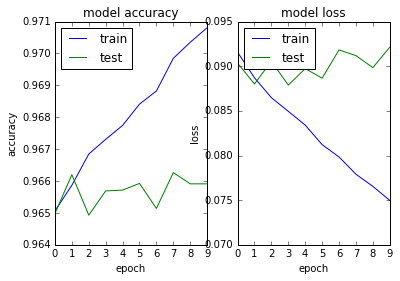

../weights/0719_0842_ResNet50_256_Adam_fold9-0_freeze_topblock_loss_0.0879_acc_0.9663_.h5
['../weights/0719', '0842', 'ResNet50', '256', 'Adam', 'fold9-0', 'freeze', 'topblock', 'loss', '0.0879', 'acc', '0.9663', '.h5']
fold9-0 9 0
test x (4497, 256, 256, 3)   y (4497, 17)
ResNet50 256 17 sigmoid
0.921137871874 [0.21, 0.2, 0.14, 0.26, 0.13, 0.16, 0.25, 0.26, 0.21, 0.02, 0.15, 0.75, 0.12, 0.24, 0.09, 0.38, 0.04]


/root/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [8]:
run_train('ResNet50', (256,256,3), fold_num=9, validation_no=0, freeze_layer_type='topblock', optimizer='Adam')

In [ ]:
run_train('ResNet50', (256,256,3), fold_num=9, validation_no=0, freeze_layer_type='topblock', optimizer='SGD')

train x (35982, 256, 256, 3)   y (35982, 17)
test x (4497, 256, 256, 3)   y (4497, 17)
freeze_layer= 17
start train ResNet50 (256, 256, 3)   optimizer= SGD  freeze_layer_type= topblock
bach size= 72
Epoch 1/1000
345/499 [===================>..........] - ETA: 122s - loss: 0.2998 - acc: 0.8813

train x (32384, 224, 224, 3)   y (32384, 17)
test x (8095, 224, 224, 3)   y (8095, 17)
freeze_layer= 17
start train ResNet50 (224, 224, 3)   optimizer= Adam  freeze_layer_type= topblock
bach size= 96
Epoch 1/1000
337/337 [==============================] - 317s - loss: 0.1385 - acc: 0.9481 - val_loss: 0.3572 - val_acc: 0.8228
Epoch 2/1000
337/337 [==============================] - 311s - loss: 0.1171 - acc: 0.9564 - val_loss: 0.4683 - val_acc: 0.8175
Epoch 3/1000
337/337 [==============================] - 317s - loss: 0.1123 - acc: 0.9582 - val_loss: 0.2051 - val_acc: 0.9152
Epoch 4/1000
337/337 [==============================] - 319s - loss: 0.1097 - acc: 0.9591 - val_loss: 0.1166 - val_acc: 0.9562
Epoch 5/1000
337/337 [==============================] - 311s - loss: 0.1081 - acc: 0.9596 - val_loss: 0.1118 - val_acc: 0.9570
Epoch 6/1000
337/337 [==============================] - 313s - loss: 0.1056 - acc: 0.9606 - val_loss: 0.1065 - val_acc: 0.9617
Epoch 7/1000
337/337 [================

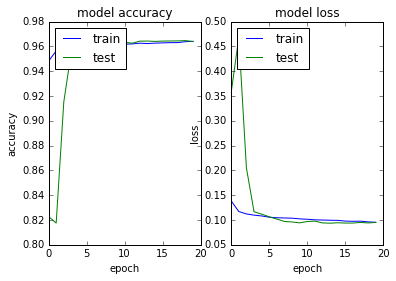

../weights/0717_1504_ResNet50_224_Adam_fold5-0_freeze_topblock_loss_0.0936_acc_0.9647_


In [8]:
# flatten
run_train('ResNet50', (224,224,3), fold_num=5, validation_no=0, freeze_layer_type='topblock', optimizer='Adam')

### ResNet50 224px fold=5

x_train (32384, 224, 224, 3)   y_train (32384, 17)
x_test (8095, 224, 224, 3)   y_test (8095, 17)
freeze_layer= 17
start train ResNet50 (224, 224, 3)   optimizer= Adam  freeze_layer_type= topblock
bach size= 96
Epoch 1/100
337/337 [==============================] - 317s - loss: 0.1327 - acc: 0.9502 - val_loss: 0.3822 - val_acc: 0.8408
Epoch 2/100
337/337 [==============================] - 310s - loss: 0.1132 - acc: 0.9578 - val_loss: 0.4729 - val_acc: 0.7846
Epoch 3/100
337/337 [==============================] - 311s - loss: 0.1082 - acc: 0.9595 - val_loss: 0.2387 - val_acc: 0.8972
Epoch 4/100
337/337 [==============================] - 310s - loss: 0.1060 - acc: 0.9601 - val_loss: 0.1119 - val_acc: 0.9585
Epoch 5/100
337/337 [==============================] - 310s - loss: 0.1037 - acc: 0.9612 - val_loss: 0.0990 - val_acc: 0.9627
Epoch 6/100
337/337 [==============================] - 310s - loss: 0.1022 - acc: 0.9615 - val_loss: 0.1019 - val_acc: 0.9619
Epoch 7/100
337/337 [============

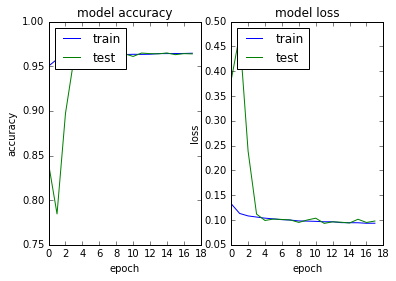

../weights/0712_2118_ResNet50_224_Adam_fold5-0_freeze_topblock_loss_0.0932_acc_0.9649_


In [4]:
run_train('ResNet50', (224,224,3), fold_num=5, test_dataset_no=0, freeze_layer_type='topblock', optimizer='Adam')

In [4]:
run_train('ResNet50', (224,224,3), fold_num=5, test_dataset_no=0, freeze_layer_type='topblock', optimizer='Adam')

x_train (32384, 224, 224, 3)   y_train (32384, 17)
x_test (8095, 224, 224, 3)   y_test (8095, 17)
freeze_layer= 17
start train ResNet50 (224, 224, 3)   optimizer= Adam  freeze_layer_type= topblock
bach size= 96
Epoch 1/100
337/337 [==============================] - 317s - loss: 0.2474 - acc: 0.9014 - val_loss: 0.4722 - val_acc: 0.7417
Epoch 2/100
337/337 [==============================] - 310s - loss: 0.1201 - acc: 0.9563 - val_loss: 0.5228 - val_acc: 0.7446
Epoch 3/100
337/337 [==============================] - 311s - loss: 0.1082 - acc: 0.9600 - val_loss: 0.2236 - val_acc: 0.9134
Epoch 4/100
337/337 [==============================] - 311s - loss: 0.1030 - acc: 0.9617 - val_loss: 0.1019 - val_acc: 0.9624
Epoch 5/100
337/337 [==============================] - 310s - loss: 0.0998 - acc: 0.9626 - val_loss: 0.0957 - val_acc: 0.9639
Epoch 6/100
337/337 [==============================] - 311s - loss: 0.0967 - acc: 0.9637 - val_loss: 0.0932 - val_acc: 0.9652
Epoch 7/100
337/337 [============

TypeError: Can't convert 'int' object to str implicitly

train x (32384, 128, 128, 3)   y (32384, 17)
test x (8095, 128, 128, 3)   y (8095, 17)
freeze_layer= 72
start train DenseNet121 (128, 128, 3)   optimizer= Adam  freeze_layer_type= topblock
bach size= 198
Epoch 1/1000
163/163 [==============================] - 155s - loss: 0.1302 - acc: 0.9498 - val_loss: 0.2318 - val_acc: 0.9220
Epoch 2/1000
163/163 [==============================] - 124s - loss: 0.1029 - acc: 0.9607 - val_loss: 0.1836 - val_acc: 0.9282
Epoch 3/1000
163/163 [==============================] - 124s - loss: 0.0993 - acc: 0.9621 - val_loss: 0.1045 - val_acc: 0.9606
Epoch 4/1000
163/163 [==============================] - 124s - loss: 0.0974 - acc: 0.9627 - val_loss: 0.1000 - val_acc: 0.9600
Epoch 5/1000
163/163 [==============================] - 124s - loss: 0.0960 - acc: 0.9628 - val_loss: 0.0937 - val_acc: 0.9646
Epoch 6/1000
163/163 [==============================] - 124s - loss: 0.0936 - acc: 0.9642 - val_loss: 0.0928 - val_acc: 0.9645
Epoch 7/1000
163/163 [============

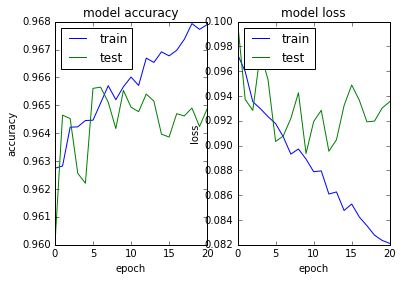

../weights/0717_2305_DenseNet121_128_Adam_fold5-0_freeze_topblock_loss_0.0894_acc_0.9657_.h5
['../weights/0717', '2305', 'DenseNet121', '128', 'Adam', 'fold5-0', 'freeze', 'topblock', 'loss', '0.0894', 'acc', '0.9657', '.h5']
fold5-0 5 0
test x (8095, 128, 128, 3)   y (8095, 17)
DenseNet121 128 17 sigmoid
0.921991980513 [0.1, 0.18, 0.22, 0.15, 0.16, 0.22, 0.24, 0.25, 0.19, 0.02, 0.26, 0.38, 0.15, 0.05, 0.14, 0.21, 0.06]


/root/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [8]:
run_train('DenseNet121', (128,128,3), fold_num=5, validation_no=0, freeze_layer_type='topblock', optimizer='Adam')

train x (32384, 128, 128, 3)   y (32384, 17)
test x (8095, 128, 128, 3)   y (8095, 17)
freeze_layer= 72
start train DenseNet121 (128, 128, 3)   optimizer= Adam  freeze_layer_type= topblock
bach size= 198
Epoch 1/1000
163/163 [==============================] - 155s - loss: 0.1306 - acc: 0.9496 - val_loss: 0.2844 - val_acc: 0.8883
Epoch 2/1000
163/163 [==============================] - 124s - loss: 0.1021 - acc: 0.9612 - val_loss: 0.1662 - val_acc: 0.9370
Epoch 3/1000
163/163 [==============================] - 124s - loss: 0.0985 - acc: 0.9623 - val_loss: 0.1073 - val_acc: 0.9577
Epoch 4/1000
163/163 [==============================] - 127s - loss: 0.0962 - acc: 0.9630 - val_loss: 0.1024 - val_acc: 0.9621
Epoch 5/1000
163/163 [==============================] - 124s - loss: 0.0946 - acc: 0.9636 - val_loss: 0.0913 - val_acc: 0.9642
Epoch 6/1000
163/163 [==============================] - 123s - loss: 0.0930 - acc: 0.9643 - val_loss: 0.0945 - val_acc: 0.9637
Epoch 7/1000
163/163 [============

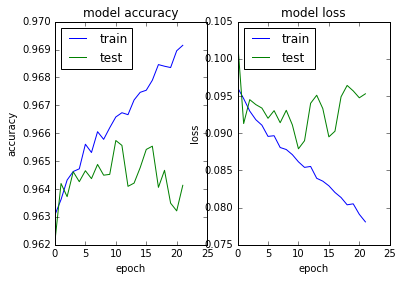

../weights/0718_1245_DenseNet121_128_Adam_fold5-0_freeze_topblock_loss_0.0879_acc_0.9657_.h5
['../weights/0718', '1245', 'DenseNet121', '128', 'Adam', 'fold5-0', 'freeze', 'topblock', 'loss', '0.0879', 'acc', '0.9657', '.h5']
fold5-0 5 0
test x (8095, 128, 128, 3)   y (8095, 17)
DenseNet121 128 17 sigmoid
0.919849772463 [0.21, 0.16, 0.37, 0.08, 0.21, 0.27, 0.42, 0.25, 0.09, 0.02, 0.25, 0.11, 0.14, 0.03, 0.55, 0.33, 0.07]


/root/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [8]:
run_train('DenseNet121', (128,128,3), fold_num=5, validation_no=0, freeze_layer_type='topblock', optimizer='Adam')

train x (32384, 128, 128, 3)   y (32384, 17)
test x (8095, 128, 128, 3)   y (8095, 17)
freeze_layer= 72
start train DenseNet121 (128, 128, 3)   optimizer= Adam  freeze_layer_type= topblock
bach size= 198
Epoch 1/1000
163/163 [==============================] - 186s - loss: 0.1223 - acc: 0.9528 - val_loss: 0.2443 - val_acc: 0.9081
Epoch 2/1000
163/163 [==============================] - 118s - loss: 0.0982 - acc: 0.9622 - val_loss: 0.1731 - val_acc: 0.9339
Epoch 3/1000
163/163 [==============================] - 118s - loss: 0.0942 - acc: 0.9637 - val_loss: 0.1194 - val_acc: 0.9533
Epoch 4/1000
163/163 [==============================] - 118s - loss: 0.0925 - acc: 0.9642 - val_loss: 0.1008 - val_acc: 0.9601
Epoch 5/1000
163/163 [==============================] - 118s - loss: 0.0900 - acc: 0.9651 - val_loss: 0.1004 - val_acc: 0.9619
Epoch 6/1000
163/163 [==============================] - 118s - loss: 0.0890 - acc: 0.9655 - val_loss: 0.0936 - val_acc: 0.9640
Epoch 7/1000
163/163 [============

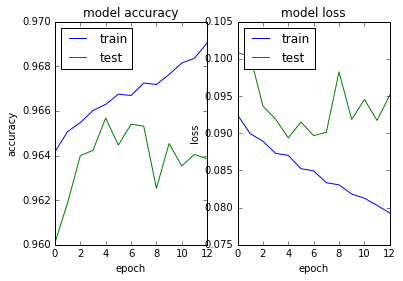

../weights/0718_1319_DenseNet121_128_Adam_fold5-0_freeze_topblock_loss_0.0894_acc_0.9657_.h5
['../weights/0718', '1319', 'DenseNet121', '128', 'Adam', 'fold5-0', 'freeze', 'topblock', 'loss', '0.0894', 'acc', '0.9657', '.h5']
fold5-0 5 0
test x (8095, 128, 128, 3)   y (8095, 17)
DenseNet121 128 17 sigmoid
0.918636619764 [0.14, 0.19, 0.28, 0.23, 0.17, 0.19, 0.14, 0.38, 0.77, 0.04, 0.18, 0.43, 0.12, 0.06, 0.54, 0.21, 0.05]


/root/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [10]:

run_train('DenseNet121', (128,128,3), fold_num=5, validation_no=0, freeze_layer_type='topblock', optimizer='Adam')

train x (32384, 128, 128, 3)   y (32384, 17)
test x (8095, 128, 128, 3)   y (8095, 17)
freeze_layer= 72
start train DenseNet161 (128, 128, 3)   optimizer= Adam  freeze_layer_type= topblock
bach size= 64
Epoch 1/1000
506/506 [==============================] - 328s - loss: 0.0956 - acc: 0.9635 - val_loss: 0.0926 - val_acc: 0.9643
Epoch 2/1000
506/506 [==============================] - 273s - loss: 0.0939 - acc: 0.9638 - val_loss: 0.0884 - val_acc: 0.9662
Epoch 3/1000
506/506 [==============================] - 272s - loss: 0.0926 - acc: 0.9644 - val_loss: 0.0946 - val_acc: 0.9629
Epoch 4/1000
506/506 [==============================] - 274s - loss: 0.0925 - acc: 0.9644 - val_loss: 0.0878 - val_acc: 0.9661
Epoch 5/1000
506/506 [==============================] - 272s - loss: 0.0918 - acc: 0.9647 - val_loss: 0.0890 - val_acc: 0.9658
Epoch 6/1000
506/506 [==============================] - 272s - loss: 0.0916 - acc: 0.9649 - val_loss: 0.0891 - val_acc: 0.9657
Epoch 7/1000
506/506 [=============

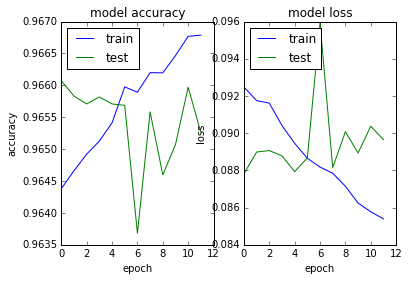

../weights/0718_0907_DenseNet161_128_Adam_fold5-0_freeze_topblock_loss_0.0878_acc_0.9662_.h5
['../weights/0718', '0907', 'DenseNet161', '128', 'Adam', 'fold5-0', 'freeze', 'topblock', 'loss', '0.0878', 'acc', '0.9662', '.h5']
fold5-0 5 0
test x (8095, 128, 128, 3)   y (8095, 17)
DenseNet161 128 17 sigmoid
0.92282300892 [0.3, 0.36, 0.21, 0.13, 0.22, 0.21, 0.22, 0.25, 0.18, 0.07, 0.16, 0.19, 0.19, 0.21, 0.1, 0.07, 0.13]


/root/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [8]:
run_train('DenseNet161', (128,128,3), fold_num=5, validation_no=0, freeze_layer_type='topblock', optimizer='Adam')

train x (32384, 128, 128, 3)   y (32384, 17)
test x (8095, 128, 128, 3)   y (8095, 17)
start train DenseNet161 (128, 128, 3)   optimizer= Adam  freeze_layer_type= None
bach size= 56
Epoch 1/1000
578/578 [==============================] - 403s - loss: 0.1942 - acc: 0.9365 - val_loss: 0.1202 - val_acc: 0.9597
Epoch 2/1000
578/578 [==============================] - 344s - loss: 0.1042 - acc: 0.9616 - val_loss: 0.0938 - val_acc: 0.9645
Epoch 3/1000
578/578 [==============================] - 344s - loss: 0.0951 - acc: 0.9640 - val_loss: 0.0917 - val_acc: 0.9651
Epoch 4/1000
578/578 [==============================] - 344s - loss: 0.0914 - acc: 0.9649 - val_loss: 0.0906 - val_acc: 0.9650
Epoch 5/1000
578/578 [==============================] - 349s - loss: 0.0884 - acc: 0.9662 - val_loss: 0.0887 - val_acc: 0.9654
Epoch 6/1000
578/578 [==============================] - 342s - loss: 0.0861 - acc: 0.9669 - val_loss: 0.0890 - val_acc: 0.9650
Epoch 7/1000
578/578 [==============================] - 

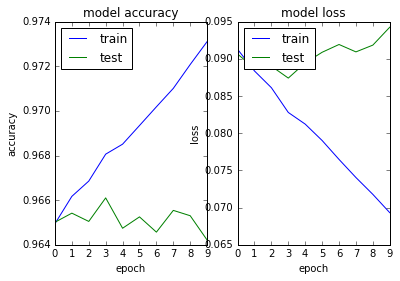

../weights/0718_1657_DenseNet161_128_Adam_fold5-0_loss_0.0874_acc_0.9661_.h5
['../weights/0718', '1657', 'DenseNet161', '128', 'Adam', 'fold5-0', 'loss', '0.0874', 'acc', '0.9661', '.h5']
fold5-0 5 0
test x (8095, 128, 128, 3)   y (8095, 17)
DenseNet161 128 17 sigmoid
0.918063680021 [0.22, 0.36, 0.12, 0.13, 0.23, 0.23, 0.13, 0.19, 0.09, 0.03, 0.1, 0.27, 0.44, 0.13, 0.3, 0.14, 0.12]


/root/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [8]:
run_train('DenseNet161', (128,128,3), fold_num=5, validation_no=0)

In [8]:
run_train('DenseNet161', (128,128,3), fold_num=5, validation_no=0)

train x (32384, 128, 128, 3)   y (32384, 17)
test x (8095, 128, 128, 3)   y (8095, 17)
start train DenseNet161 (128, 128, 3)   optimizer= Adam  freeze_layer_type= None
bach size= 56
Epoch 1/1000
578/578 [==============================] - 404s - loss: 0.1718 - acc: 0.9432 - val_loss: 0.1043 - val_acc: 0.9611
Epoch 2/1000
578/578 [==============================] - 344s - loss: 0.1019 - acc: 0.9621 - val_loss: 0.0928 - val_acc: 0.9646
Epoch 3/1000
578/578 [==============================] - 344s - loss: 0.0949 - acc: 0.9640 - val_loss: 0.0889 - val_acc: 0.9657
Epoch 4/1000
578/578 [==============================] - 344s - loss: 0.0911 - acc: 0.9651 - val_loss: 0.0881 - val_acc: 0.9660
Epoch 5/1000
578/578 [==============================] - 343s - loss: 0.0880 - acc: 0.9661 - val_loss: 0.0899 - val_acc: 0.9651
Epoch 6/1000
578/578 [==============================] - 345s - loss: 0.0854 - acc: 0.9671 - val_loss: 0.0877 - val_acc: 0.9660
Epoch 7/1000
578/578 [==============================] - 

KeyboardInterrupt: 

x_train (36432, 256, 256, 3)   y_train (36432, 17)
x_test (4047, 256, 256, 3)   y_test (4047, 17)
freeze_layer= 72
start train DenseNet121 (256, 256, 3)   optimizer= Adam  freeze_layer_type= topblock
bach size= 52
Epoch 1/100
700/700 [==============================] - 543s - loss: 0.1218 - acc: 0.9539 - val_loss: 0.1098 - val_acc: 0.9573
Epoch 2/100
700/700 [==============================] - 513s - loss: 0.1055 - acc: 0.9604 - val_loss: 0.1255 - val_acc: 0.9547
Epoch 3/100
700/700 [==============================] - 513s - loss: 0.1018 - acc: 0.9614 - val_loss: 0.1172 - val_acc: 0.9586
Epoch 4/100
700/700 [==============================] - 514s - loss: 0.0988 - acc: 0.9624 - val_loss: 0.0962 - val_acc: 0.9633
Epoch 5/100
700/700 [==============================] - 513s - loss: 0.0967 - acc: 0.9633 - val_loss: 0.0994 - val_acc: 0.9623
Epoch 6/100
700/700 [==============================] - 514s - loss: 0.0958 - acc: 0.9635 - val_loss: 0.0934 - val_acc: 0.9648
Epoch 7/100
700/700 [=========

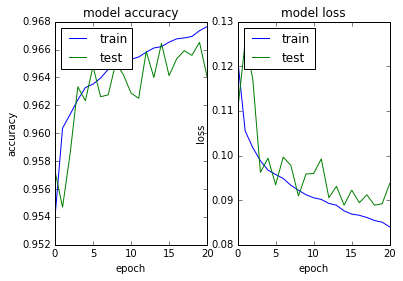

../weights/0714_1256_DenseNet121_256_Adam_fold10-0_freeze_topblock_loss_0.0889_acc_0.9665_


In [4]:
run_train('DenseNet121', (256,256,3), fold_num=10, test_dataset_no=0, freeze_layer_type='topblock', optimizer='Adam')

x_train (36432, 256, 256, 3)   y_train (36432, 17)
x_test (4047, 256, 256, 3)   y_test (4047, 17)
freeze_layer= 72
start train DenseNet121 (256, 256, 3)   optimizer= Adam  freeze_layer_type= topblock
bach size= 52
Epoch 1/100
700/700 [==============================] - 545s - loss: 0.1235 - acc: 0.9533 - val_loss: 0.1139 - val_acc: 0.9578
Epoch 2/100
700/700 [==============================] - 515s - loss: 0.1082 - acc: 0.9595 - val_loss: 0.1118 - val_acc: 0.9580
Epoch 3/100
700/700 [==============================] - 515s - loss: 0.1046 - acc: 0.9606 - val_loss: 0.0979 - val_acc: 0.9629
Epoch 4/100
700/700 [==============================] - 514s - loss: 0.1019 - acc: 0.9614 - val_loss: 0.1008 - val_acc: 0.9622
Epoch 5/100
700/700 [==============================] - 514s - loss: 0.0995 - acc: 0.9622 - val_loss: 0.0992 - val_acc: 0.9611
Epoch 6/100
700/700 [==============================] - 515s - loss: 0.0982 - acc: 0.9627 - val_loss: 0.0934 - val_acc: 0.9640
Epoch 7/100
700/700 [=========

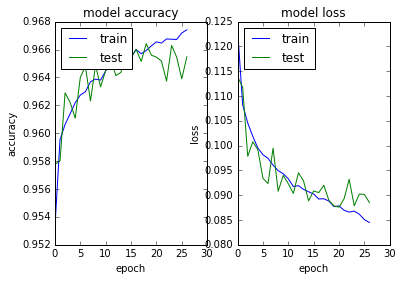

../weights/0715_1835_DenseNet121_256_Adam_fold10-0_freeze_topblock_loss_0.0876_acc_0.9664_


In [4]:
run_train('DenseNet121', (256,256,3), fold_num=10, test_dataset_no=0, freeze_layer_type='topblock', optimizer='Adam')

x_train (36432, 256, 256, 3)   y_train (36432, 17)
x_test (4047, 256, 256, 3)   y_test (4047, 17)
freeze_layer= 17
start train ResNet50 (256, 256, 3)   optimizer= Adam  freeze_layer_type= topblock
bach size= 72
Epoch 1/100
506/506 [==============================] - 422s - loss: 0.1327 - acc: 0.9502 - val_loss: 0.4662 - val_acc: 0.8672
Epoch 2/100
506/506 [==============================] - 406s - loss: 0.1126 - acc: 0.9574 - val_loss: 0.1847 - val_acc: 0.9190
Epoch 3/100
506/506 [==============================] - 406s - loss: 0.1086 - acc: 0.9589 - val_loss: 0.1235 - val_acc: 0.9561
Epoch 4/100
506/506 [==============================] - 405s - loss: 0.1048 - acc: 0.9606 - val_loss: 0.1060 - val_acc: 0.9599
Epoch 5/100
506/506 [==============================] - 405s - loss: 0.1029 - acc: 0.9610 - val_loss: 0.0993 - val_acc: 0.9607
Epoch 6/100
506/506 [==============================] - 405s - loss: 0.1013 - acc: 0.9617 - val_loss: 0.1025 - val_acc: 0.9603
Epoch 7/100
506/506 [============

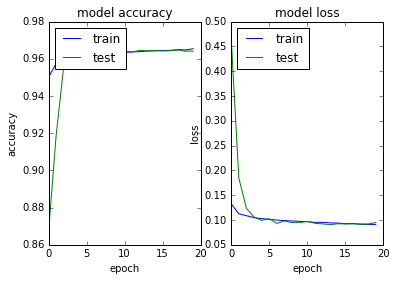

../weights/0715_2051_ResNet50_256_Adam_fold10-0_freeze_topblock_loss_0.0905_acc_0.9647_


In [5]:
run_train('ResNet50', (256,256,3), fold_num=10, test_dataset_no=0, freeze_layer_type='topblock', optimizer='Adam')

x_train (36432, 256, 256, 3)   y_train (36432, 17)
x_test (4047, 256, 256, 3)   y_test (4047, 17)
freeze_layer= 16
start train Xception (256, 256, 3)   optimizer= Adam  freeze_layer_type= topblock
bach size= 52
Epoch 1/100
700/700 [==============================] - 514s - loss: 0.1276 - acc: 0.9527 - val_loss: 0.1216 - val_acc: 0.9558
Epoch 2/100
700/700 [==============================] - 515s - loss: 0.1111 - acc: 0.9583 - val_loss: 0.1097 - val_acc: 0.9579
Epoch 3/100
700/700 [==============================] - 516s - loss: 0.1075 - acc: 0.9597 - val_loss: 0.1018 - val_acc: 0.9606
Epoch 4/100
700/700 [==============================] - 515s - loss: 0.1041 - acc: 0.9608 - val_loss: 0.1008 - val_acc: 0.9610
Epoch 5/100
700/700 [==============================] - 515s - loss: 0.1023 - acc: 0.9611 - val_loss: 0.0986 - val_acc: 0.9620
Epoch 6/100
700/700 [==============================] - 515s - loss: 0.1009 - acc: 0.9618 - val_loss: 0.1044 - val_acc: 0.9602
Epoch 7/100
700/700 [============

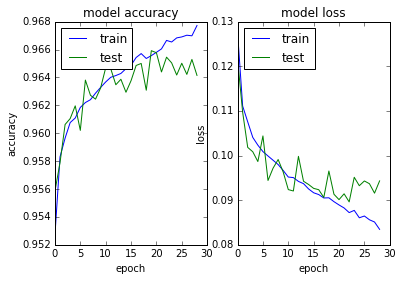

../weights/0715_1230_Xception_256_Adam_fold10-0_freeze_topblock_loss_0.0896_acc_0.9659_


In [8]:
history = run_train('Xception', (256,256,3), fold_num=10, test_dataset_no=0, freeze_layer_type='topblock', optimizer='Adam')

# F score

In [9]:
weights = ['../weights/0717_2055_ResNet50_224_Adam_fold5-0_freeze_topblock_loss_0.0911_acc_0.9656_.h5']
for i in range( len(weights) ):
    y_test, y_pred = run_check(weights[i])
    get_optimal_threshhold(y_test, y_pred)

['../weights/0717', '2055', 'ResNet50', '224', 'Adam', 'fold5-0', 'freeze', 'topblock', 'loss', '0.0911', 'acc', '0.9656', '.h5']
fold5-0 5 0
test x (8095, 224, 224, 3)   y (8095, 17)
ResNet50 224 17 sigmoid
0.922758464495 [0.15, 0.19, 0.28, 0.27, 0.17, 0.17, 0.26, 0.21, 0.13, 0.12, 0.23, 0.32, 0.14, 0.16, 0.13, 0.23, 0.04]


/root/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [8]:
weights = ['../weights/0718_0907_DenseNet161_128_Adam_fold5-0_freeze_topblock_loss_0.0878_acc_0.9662_.h5']
for i in range( len(weights) ):
    y_test, y_pred = run_check(weights[i])
    get_optimal_threshhold(y_test, y_pred)

['../weights/0718', '0907', 'DenseNet161', '128', 'Adam', 'fold5-0', 'freeze', 'topblock', 'loss', '0.0878', 'acc', '0.9662', '.h5']
fold5-0 5 0
test x (8095, 256, 256, 3)   y (8095, 17)
DenseNet161 256 17 sigmoid
0.879696118528 [0.24, 0.29, 0.16, 0.32, 0.17, 0.09, 0.14, 0.09, 0.41, 0.15, 0.02, 0.07, 0.09, 0.05, 0.05, 0.03, 0.1]


/root/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [8]:
weights = ['../weights/0718_0907_DenseNet161_128_Adam_fold5-0_freeze_topblock_loss_0.0878_acc_0.9662_.h5']
for i in range( len(weights) ):
    y_test, y_pred = run_check(weights[i])
    get_optimal_threshhold(y_test, y_pred)

['../weights/0718', '0907', 'DenseNet161', '128', 'Adam', 'fold5-0', 'freeze', 'topblock', 'loss', '0.0878', 'acc', '0.9662', '.h5']
fold5-0 5 0
test x (8095, 128, 128, 3)   y (8095, 17)
DenseNet161 128 17 sigmoid
0.92282300892 [0.3, 0.36, 0.21, 0.13, 0.22, 0.21, 0.22, 0.25, 0.18, 0.07, 0.16, 0.19, 0.19, 0.21, 0.1, 0.07, 0.13]


/root/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [9]:
weights = ['../weights/0712_0030_ResNet50_224_Adam_fold5-0_freeze_topblock_loss_0.0879_acc_0.9662.h5']
for i in range( len(weights) ):
    y_test, y_pred = run_check(weights[i])
    get_optimal_threshhold(y_test, y_pred)

['../weights/0712', '0030', 'ResNet50', '224', 'Adam', 'fold5-0', 'freeze', 'topblock', 'loss', '0.0879', 'acc', '0.9662.h5']
fold5-0 5 0
test x (8095, 224, 224, 3)   y (8095, 17)
ResNet50 224 17 sigmoid
0.920460531063 [0.14, 0.21, 0.15, 0.21, 0.22, 0.2, 0.19, 0.15, 0.11, 0.06, 0.1, 0.22, 0.16, 0.45, 0.18, 0.11, 0.07]


/root/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [10]:
weights = ['../fullweights/0719_1206_ResNet50_256_14_0.0818_0.9685.h5',
                    '../fullweights/0719_1407_ResNet50_256_14_0.0816_0.9685.h5',
                    '../fullweights/0719_1943_ResNet50_256_14_0.0818_0.9685.h5',
                    '../fullweights/0720_0840_ResNet50_256_14_0.0818_0.9684.h5',
                    '../fullweights/0720_1056_ResNet50_256_14_0.0816_0.9686.h5']
for i in range( len(weights) ):
    r = run_full_check(weights[i])

['../fullweights/0719', '1206', 'ResNet50', '256', '14', '0.0818', '0.9685.h5']
load dataset complete
model complete
../fullweights/0719_1206_ResNet50_256_14_0.0818_0.9685.h5_normal_normal_train_predict.npz
../fullweights/0719_1206_ResNet50_256_14_0.0818_0.9685.h5_normal_90_train_predict.npz
../fullweights/0719_1206_ResNet50_256_14_0.0818_0.9685.h5_lr_normal_train_predict.npz
../fullweights/0719_1206_ResNet50_256_14_0.0818_0.9685.h5_lr_90_train_predict.npz
../fullweights/0719_1206_ResNet50_256_14_0.0818_0.9685.h5_ud_normal_train_predict.npz
../fullweights/0719_1206_ResNet50_256_14_0.0818_0.9685.h5_ud_90_train_predict.npz
../fullweights/0719_1206_ResNet50_256_14_0.0818_0.9685.h5_udlr_normal_train_predict.npz
../fullweights/0719_1206_ResNet50_256_14_0.0818_0.9685.h5_udlr_90_train_predict.npz
['../fullweights/0719', '1407', 'ResNet50', '256', '14', '0.0816', '0.9685.h5']
load dataset complete
model complete
../fullweights/0719_1407_ResNet50_256_14_0.0816_0.9685.h5_normal_normal_train_pred

In [11]:
print(r)

[array([ 0.19,  0.18,  0.27,  0.15,  0.15,  0.23,  0.27,  0.22,  0.28,
        0.2 ,  0.17,  0.14,  0.2 ,  0.07,  0.37,  0.19,  0.1 ]), array([ 0.18,  0.13,  0.22,  0.16,  0.16,  0.22,  0.27,  0.23,  0.23,
        0.18,  0.16,  0.24,  0.27,  0.05,  0.22,  0.18,  0.12]), array([ 0.19,  0.16,  0.19,  0.1 ,  0.17,  0.27,  0.27,  0.23,  0.18,
        0.21,  0.11,  0.29,  0.24,  0.09,  0.37,  0.19,  0.09]), array([ 0.18,  0.21,  0.28,  0.18,  0.15,  0.24,  0.3 ,  0.25,  0.25,
        0.19,  0.18,  0.32,  0.2 ,  0.13,  0.31,  0.16,  0.11]), array([ 0.18,  0.21,  0.26,  0.14,  0.16,  0.25,  0.31,  0.26,  0.2 ,
        0.17,  0.17,  0.24,  0.23,  0.22,  0.31,  0.19,  0.17]), array([ 0.18,  0.17,  0.22,  0.16,  0.19,  0.22,  0.25,  0.25,  0.42,
        0.14,  0.14,  0.24,  0.26,  0.05,  0.26,  0.16,  0.12]), array([ 0.18,  0.13,  0.22,  0.16,  0.16,  0.22,  0.27,  0.23,  0.23,
        0.18,  0.16,  0.24,  0.27,  0.05,  0.22,  0.18,  0.12]), array([ 0.19,  0.18,  0.27,  0.15,  0.15,  0.23,  0.27

In [12]:
means = []
for i in range(17):
    mean = 0
    for j in range(len(r)):
        mean += r[j][i]
    means.append(mean / len(r))
    

In [13]:
print(means)

[0.18374999999999997, 0.17124999999999999, 0.24124999999999999, 0.14999999999999999, 0.16124999999999998, 0.23499999999999999, 0.27625, 0.23624999999999999, 0.25874999999999998, 0.18375, 0.1575, 0.23125000000000001, 0.23374999999999999, 0.091250000000000026, 0.30375000000000002, 0.17999999999999999, 0.11624999999999999]


In [16]:
p = []
for i in range(len(weights)):
    for flip in ['normal', 'lr', 'ud', 'udlr']:
        for rotate in ['normal', 90]:
            result_path = weights[i]+'_'+flip+'_'+str(rotate)+'_train_predict.npz'
            ndarr = np.load(result_path)
            p.append(ndarr['pred'])

In [17]:
means = my_functions.mean_ensemble(p)

In [18]:
y_test = ndarr['y']
print(means[0])
print(y_test[0])
print(len(means))
print(len(y_test))

[  5.95285730e-01   9.99470580e-01   5.53134865e-03   4.12418134e-01
   1.70040751e-02   1.22043577e-03   2.87347270e-03   3.38295272e-03
   2.02359083e-04   4.07110417e-04   4.50397684e-03   1.21832731e-04
   3.42737259e-04   1.14880491e-04   6.10411901e-04   2.68941277e-04
   1.50703388e-04]
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40479
40479


In [19]:
get_optimal_threshhold(y_test, means)

0.939267843456 [0.25, 0.26, 0.23, 0.2, 0.19, 0.23, 0.3, 0.21, 0.21, 0.19, 0.2, 0.12, 0.17, 0.15, 0.28, 0.13, 0.09]


/root/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[0.25,
 0.26,
 0.23,
 0.2,
 0.19,
 0.23,
 0.3,
 0.21,
 0.21,
 0.19,
 0.2,
 0.12,
 0.17,
 0.15,
 0.28,
 0.13,
 0.09]